<a href="https://colab.research.google.com/github/EikEUFS/AprendizadoDeMaquina/blob/main/AM_Tarefa04B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download do D2L e MXNET
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.16.4

Requirement already up-to-date: mxnet-cu101==1.7.0 in /usr/local/lib/python3.7/dist-packages (1.7.0)


In [2]:
# Importacoes e Download do AUX
import collections
import math
import re
import random

from mxnet import autograd, context, gluon, image, init, np, npx
from mxnet.gluon import nn, rnn
from mxnet.gluon import utils as gutils

from d2l import mxnet as d2l

npx.set_np()

data_dir = '.'
base_url = 'https://raw.githubusercontent.com/EikEUFS/AprendizadoDeMaquina/main/_aux.py'
fname = gutils.download(base_url, path=data_dir)

import _aux

In [3]:
# Código igual do livro
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.GRU(num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.swapaxes(0, 1)
        state = self.rnn.begin_state(batch_size=X.shape[1], ctx=X.ctx)
        output, state = self.rnn(X, state)
        return output, state

# Código igual do livro
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.GRU(num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).swapaxes(0, 1)
        context = state[0][-1]
        context = np.broadcast_to(context, (X.shape[0], context.shape[0], context.shape[1]))
        X_and_context = np.concatenate((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).swapaxes(0, 1)
        return output, state

# Ler o livro selecionado
def read_book(url):
    with open(gutils.download(url), 'r', encoding='latin-1') as f:
        lines = f.readlines()
    return [re.sub('[^A-ZÀ-Úa-zà-ú]+', ' ', line).strip().lower() for line in lines]

# Ler todos os livros
def read_books():
  books = [
           'https://aplauso.imprensaoficial.com.br/edicoes/12.0.813.795/12.0.813.795.txt',
           'https://aplauso.imprensaoficial.com.br/edicoes/12.0.813.105/12.0.813.105.txt',
           'https://aplauso.imprensaoficial.com.br/edicoes/12.0.813.627/12.0.813.627.txt',
           'https://aplauso.imprensaoficial.com.br/edicoes/12.0.813.977/12.0.813.977.txt',
           'https://aplauso.imprensaoficial.com.br/edicoes/12.0.813.214/12.0.813.214.txt',
          ]

  lines = []

  for url in books:
    lines = lines + read_book(url)
  return lines  

# Carregar os dados
def load_data_nmt(batch_size, num_steps, num_examples=600):
    text = read_books()
    source = _aux.tokenize(text, 'word')
    src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = _aux.build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = _aux.build_array_nmt(source, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [4]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 800, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

loss 0.035, 13856.7 tokens/sec on gpu(0)
CPU times: user 1h 4min 21s, sys: 3min 29s, total: 1h 7min 51s
Wall time: 47min 17s


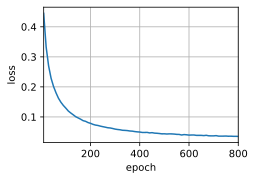

In [5]:
%%time
_aux.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [11]:
sentence_src = ['Eu', 'vou', 'escovar', 'os']
sentence_pred = []

for word_src in sentence_src:
  predict_word, _ = _aux.predict_seq2seq(net, word_src, src_vocab, tgt_vocab, 3, device)
  sentence_pred.append(predict_word)

for word_src in sentence_src:
  print(word_src, end="")
  print(' ', end="")
for word_pred in sentence_pred:
  print(word_pred, end="")
  print(' ', end="")

Eu vou escovar os eu traz história sabia joaquim que <unk> os cena fascinante 